In [211]:
import os
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

data_dir = '../data/'
plot_dir = '../plots/'

## Learning of the 2d kite
- The aggregate state is the discretized attack angle (values specified in kite.h)
- The wind velocity is constant
- The initial angle with the ground, $\theta$, is constant
- The initial attack angle can be choosen constant or random
- The algortihm is a natural actor-critic with advantage parameters. It uses two power law learning rates (the one of the critic part should be much larger) having a burn-in period in which it stays constant (see the first plot of the learning rates)

In [238]:
system_name = 'kite2d'
run_name = 'nac'

# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.0001 # sec
env_params['ep_length'] = 10 # sec
env_params['decision_time'] = 0.01 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
env_params['init_alpha'] = 15 # rad. Choosing alpha>=15 the initial attack angle is randomly chosen
env_params['v_wind_x'] = 15 # m/sec
env_params['v_wind_y'] = 0 # m/sec

# ALG PARAMETERS
alg_params = dict()
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 7000000
print('Learning steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Tot "real time" of learning, in seconds: ', alg_params['n_steps']*env_params['decision_time'])
alg_params['traj_points'] = 1000
alg_params['init_values'] = env_params['v_wind_x']*env_params['ep_length']
# Actor learning rate
alg_params['a0'] = 0.05
alg_params['ac'] = 2000
alg_params['a_expn'] = 0.67
alg_params['a_burn'] = 2000000
# Critic learning rate
alg_params['b0'] = 0.00001
alg_params['bc'] = 50000
alg_params['b_expn'] = 0.8
alg_params['b_burn'] = 4000000

Learning steps:  700000000.0
Tot "real time" of learning, in seconds:  70000.0


In [239]:
# WRITING THE PARAMETERS
try:
    os.mkdir(data_dir + system_name + '/' + run_name)
except OSError:
    print ("Creation of the directory failed")
    
f = open(data_dir + system_name + '/' + run_name + '/' + "param_env.txt", "w")
for k,v in env_params.items():
    f.write(k + "\t" + str(v) + "\n")
f.close()
    
f = open(data_dir + system_name + '/' + run_name + '/' + "param_alg.txt", "w")
for k,v in alg_params.items():
    f.write(k + "\t" + str(v) + "\n")
f.close()

Creation of the directory failed


In [225]:
# COMPILING C++ SCRIPT
comp_list = np.array(["g++", "-o", "train.exe", "train.cpp", "../lib/nac.cpp", "../lib/utils.cpp", 
            "../lib/envs/kite.cpp", "../lib/envs/"+system_name+".cpp", "-std=c++17"])
comp_str = ""
for s in comp_list: comp_str+=s+" "
print('To compile from terminal: ')
print(comp_str)
#p = subprocess.Popen(comp_str, stderr=subprocess.PIPE)
#print(p.stderr.read().decode('utf-8'))

To compile from terminal: 
g++ -o train.exe train.cpp ../lib/nac.cpp ../lib/utils.cpp ../lib/envs/kite.cpp ../lib/envs/kite2d.cpp -std=c++17 


In [219]:
# EXECUTING THE SCRIPT
# Acually it doesn't print the standard output on-line. If you want the percentage execute from shell
#p = subprocess.Popen(["./train.exe", system_name, run_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#print(p.stderr.read().decode('utf-8'))
#print(p.stdout.read().decode('utf-8'))

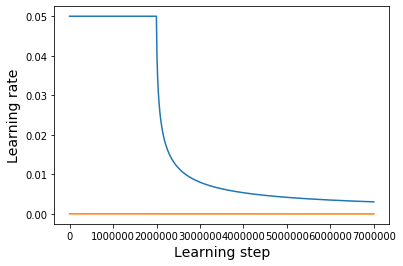

In [240]:
def p_law(x, x_burn, expn, c0, cc):
    if x < x_burn:
        return c0
    else:
        return c0*cc / (cc + (x-x_burn)**expn)
    
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Learning rate', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
crit_lr = [p_law(x, alg_params['a_burn'], alg_params['a_expn'], alg_params['a0'], alg_params['ac']) for x in xs]
act_lr = [p_law(x, alg_params['b_burn'], alg_params['b_expn'], alg_params['b0'], alg_params['bc']) for x in xs]

plt.plot(xs, crit_lr)
plt.plot(xs, act_lr)

plt.savefig(plot_dir+ system_name + '/' + run_name + '/lr.png', dpi=200)

In [241]:
import numpy as np
v_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/value_traj.txt', dtype='float')
r_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/return_traj.txt', dtype='float')

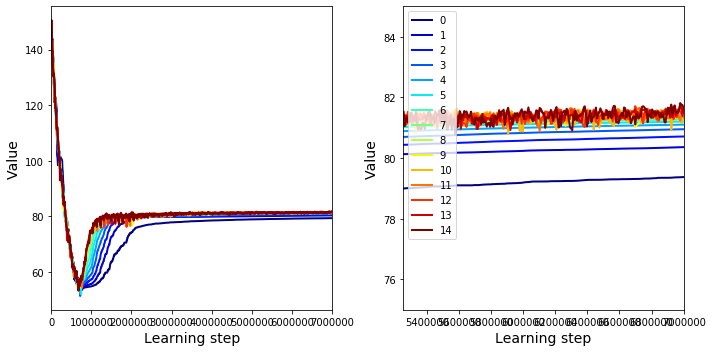

In [242]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
colors = plt.cm.jet(np.linspace(0,1,len(v_traj[0])))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Value', fontsize=14)
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in range(0,len(v_traj[0])):
    ax1.plot(xs, v_traj[:,k], c=colors[k], label=str(k), lw=2)


ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Value', fontsize=14)
ax2.set_xlim([alg_params['n_steps']/4*3,alg_params['n_steps']])
ax2.set_ylim([75,85])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in range(0,len(v_traj[0])):
    ax2.plot(xs, v_traj[:,k], c=colors[k], label=str(k), lw=2)
ax2.legend(loc=2)

plt.tight_layout()
plt.savefig(plot_dir+ system_name + '/' + run_name + '/values.png', dpi=200)

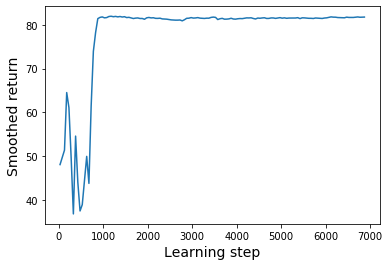

In [243]:
def smooth_traj(traj, wind_size):
    new_traj, times = [], []
    i = 0
    while i < len(traj)-wind_size:
        new_traj.append(np.mean(traj[i:i+wind_size]))
        times.append(i + wind_size/2)
        i += wind_size
    return times, new_traj

plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Smoothed return', fontsize=14)
x, y = smooth_traj(r_traj, 50)
plt.plot(x,y)

plt.savefig(plot_dir+ system_name + '/' + run_name + '/return.png', dpi=200)

In [244]:
f = open(data_dir + system_name + '/' + run_name + '/' + "policy_traj.txt", "r")
f2 = open(data_dir + system_name + '/' + run_name + '/' + "policyp_traj.txt", "r")
p_traj, par_traj = [], []
for line in f.readlines():
    policy_at_time = []
    for elem in line.split():
        policy_at_state = np.array(elem.split(','), dtype=float)
        policy_at_time.append(policy_at_state)
    p_traj.append(policy_at_time)
p_traj = np.array(p_traj)
for line in f2.readlines():
    par_at_time = []
    for elem in line.split():
        par_at_state = np.array(elem.split(','), dtype=float)
        par_at_time.append(par_at_state)
    par_traj.append(par_at_time)
par_traj = np.array(par_traj)

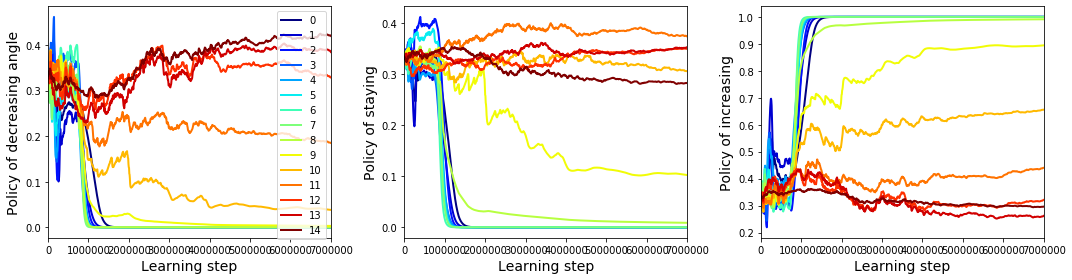

In [245]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
colors = plt.cm.jet(np.linspace(0,1,len(v_traj[0])))
states = range(0,len(p_traj[0]))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Policy of decreasing angle', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax1.plot(xs, p_traj[:,k,0], c=colors[k], label=str(k), lw=2)
ax1.legend()

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Policy of staying', fontsize=14)
ax2.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax2.plot(xs, p_traj[:,k,1], c=colors[k], label=str(k), lw=2)

ax3.set_xlabel('Learning step', fontsize=14)
ax3.set_ylabel('Policy of increasing', fontsize=14)
ax3.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax3.plot(xs, p_traj[:,k,2], c=colors[k], label=str(k), lw=2)
    
plt.tight_layout()
plt.savefig(plot_dir+ system_name + '/' + run_name + '/policies.png', dpi=200)

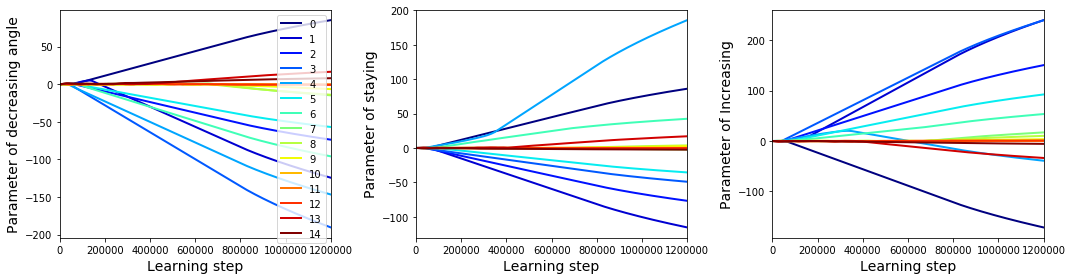

In [187]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
colors = plt.cm.jet(np.linspace(0,1,len(v_traj[0])))
states = range(len(p_traj[0]))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Parameter of decreasing angle', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax1.plot(xs, par_traj[:,k,0], c=colors[k], label=str(k), lw=2)
ax1.legend()

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Parameter of staying', fontsize=14)
ax2.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax2.plot(xs, par_traj[:,k,1], c=colors[k], label=str(k), lw=2)

ax3.set_xlabel('Learning step', fontsize=14)
ax3.set_ylabel('Parameter of Increasing', fontsize=14)
ax3.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax3.plot(xs, par_traj[:,k,2], c=colors[k], label=str(k), lw=2)
    
plt.tight_layout()

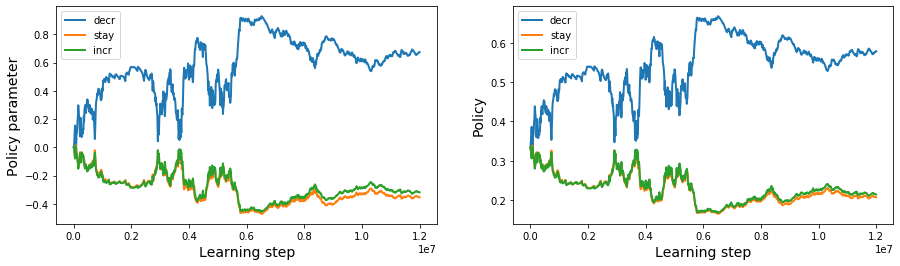

In [128]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
k=14
#ax1.set_xlim([140000,200000])
#ax1.set_ylim([-25,25])
ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Policy parameter', fontsize=14)
ax1.plot(xs, par_traj[:,k,0], label="decr", lw=2)
ax1.plot(xs, par_traj[:,k,1], label="stay", lw=2)
ax1.plot(xs, par_traj[:,k,2], label="incr", lw=2)
ax1.legend()

#ax2.set_xlim([140000,200000])
ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Policy', fontsize=14)
ax2.plot(xs, p_traj[:,k,0], label="decr", lw=2)
ax2.plot(xs, p_traj[:,k,1], label="stay", lw=2)
ax2.plot(xs, p_traj[:,k,2], label="incr", lw=2)
ax2.legend()

In [72]:
n = np.exp(6) + np.exp(7) + np.exp(-20)

In [73]:
print(np.exp(7)/n)

0.7310585786290004
